In [1]:
import os
import torch
import cv2
import random
from torchvision import transforms
import numpy as np
from PIL import Image
from IPython.display import display
from pathlib import Path

from models.experimental import attempt_load
from utils.datasets import LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box

from tools.detection import detectImage, query_element

In [2]:
# Change image path here
test_img_path = './images/test/test_1.jpeg'
# Use the default pretrained model
weights = './weights/breadboard.pt'

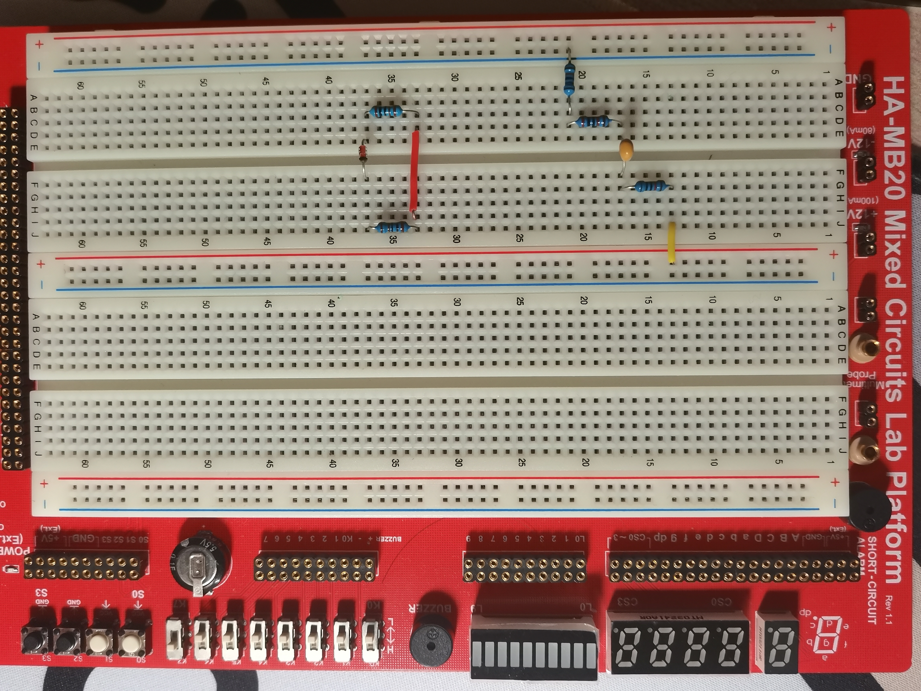

In [3]:
image = cv2.imread(test_img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# If the image's height is larger than width, rotate it
if image.shape[0] > image.shape[1]:
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite(test_img_path, image)
# Display image
display(Image.fromarray(image.astype(np.uint8)).resize((int(0.2*image.shape[1]), int(0.2*image.shape[0]))))

Fusing layers... 


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
Model Summary: 314 layers, 36524924 parameters, 6194944 gradients


RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


/Users/liyifei/opt/anaconda3/envs/yolov5/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[['Bread_Board', 103, 134, 4260, 2559], ['Capacitor', 3085, 645, 3188, 884], ['Diode', 1783, 682, 1858, 887], ['Resistor', 1801, 1102, 2126, 1178], ['Resistor', 1813, 527, 2110, 608], ['Resistor', 3087, 900, 3401, 980], ['Resistor', 2802, 231, 2894, 563], ['Resistor', 2822, 574, 3141, 653], ['Wire', 1784, 679, 1860, 891], ['Wire', 2034, 622, 2112, 1089], ['Wire', 3321, 1081, 3399, 1340]]


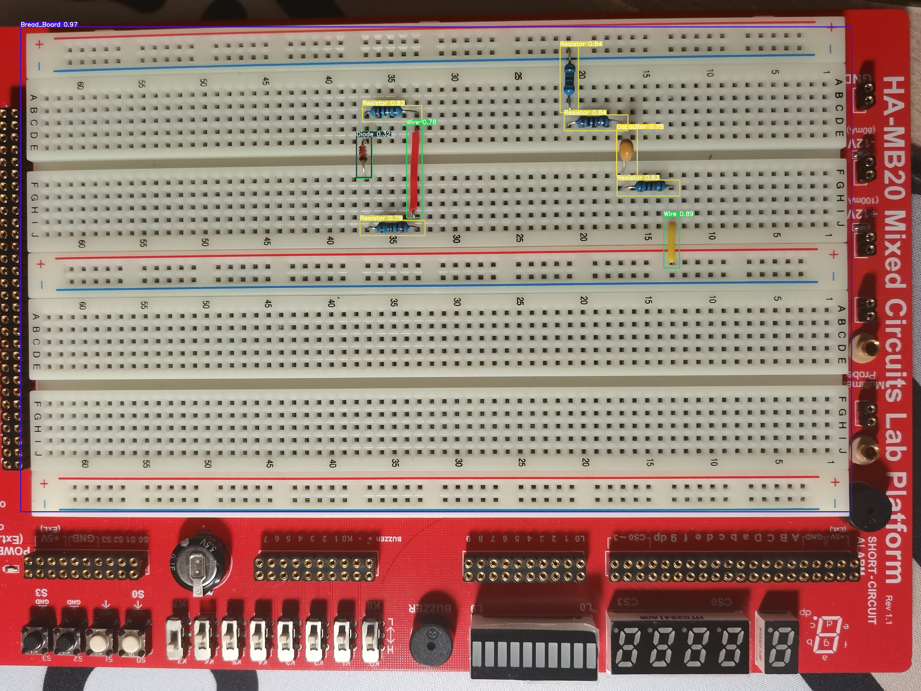

In [4]:
component_list=[]
'''
    Apply detection to the image, 
    mainly rewrite the detect() function from detect.py in yolov7
    The result is saved in "component_list"
    with the format: [label_name, x1, y1, x2, y2]
'''
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
set_logging()
half = device.type == 'cuda'  # half precision only supported on CUDA

# Load model
model = attempt_load(weights, map_location=device)  # load FP32 model
stride = int(model.stride.max())  # model stride
imgsz = check_img_size(640, s=stride)  # check img_size
if half:
    model.half()  # to FP16

# Set dataloader
dataset = LoadImages(test_img_path, img_size=imgsz, stride=stride)

# Get names and colors
names = model.module.names if hasattr(model, 'module') else model.names
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]

# Run inference
if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
old_img_w = old_img_h = imgsz
old_img_b = 1

# Inference
for path, img, im0s, vid_cap in dataset:
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    
    # Warmup
    if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
        old_img_b = img.shape[0]
        old_img_h = img.shape[2]
        old_img_w = img.shape[3]
        for i in range(3):
            model(img, agument=False)[0]
        
    # Inference
    with torch.no_grad():
        pred = model(img, augment=False)[0]
    
    # Apply NMS
    conf_thres = 0.25
    pred = non_max_suppression(pred, conf_thres, 0.5, classes=None, agnostic=False)

    # Process detections
    for i, det in enumerate(pred):  # detections per image
        p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)
        p = Path(p)  # to Path
        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        if len(det):
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
            
            # Print results
            for c in det[:, -1].unique():
                n = (det[:, -1] == c).sum()
                s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

            # Write results
            for *xyxy, conf, cls in reversed(det):
                label = f'{names[int(cls)]} {conf:.2f}'
                plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=3)
                x1, y1, x2, y2 = int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])
                component_list.append([names[int(cls)], x1, y1, x2, y2])
    
    component_list = sorted(component_list, key=lambda x: x[0])
    print(component_list)
    # Display image
    im0 = cv2.cvtColor(im0, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(im0.astype(np.uint8)).resize((int(0.2*im0.shape[1]), int(0.2*im0.shape[0]))))

[['Capacitor', 3085, 645, 3188, 884], ['Diode', 1680, 548, 1755, 753], ['Resistor', 1698, 968, 2023, 1044], ['Resistor', 1710, 393, 2007, 474], ['Resistor', 2984, 766, 3298, 846], ['Resistor', 2699, 97, 2791, 429], ['Resistor', 2719, 440, 3038, 519], ['Wire', 1681, 545, 1757, 757], ['Wire', 1931, 488, 2009, 955], ['Wire', 3218, 947, 3296, 1206]]


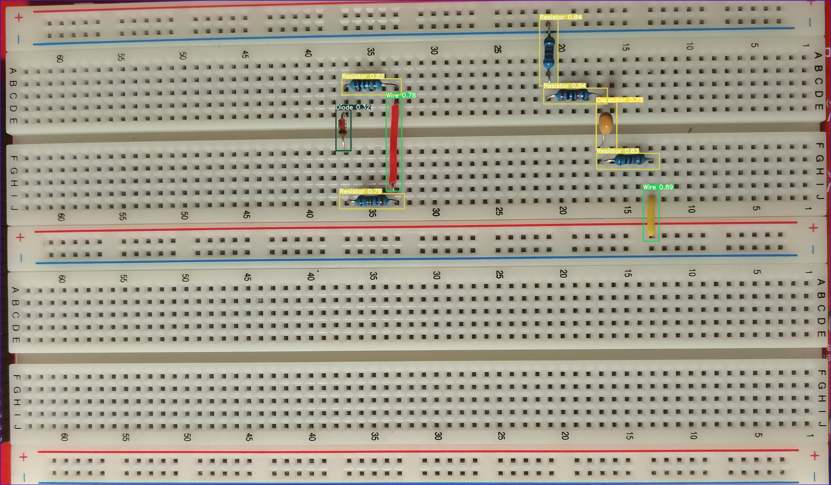

In [5]:
'''
    Segment the picture to the breadboard scope
'''
breadboard_coords = []
for component in component_list:
    if component[0] == 'Bread_Board':
        breadboard_coords.append(component[1:])
        break
# apply coordinate change to the original box range
for component in component_list:
    if component[0] != 'Bread_Board':
        component[1] = component[1] - breadboard_coords[0][0]
        component[2] = component[2] - breadboard_coords[0][1]
        component[3] = component[3] - breadboard_coords[0][0]
        component[4] = component[4] - breadboard_coords[0][1]
    # remove the breadboard from the list
    else:
        component_list.remove(component)
print(component_list)
# Segment the picture to the breadboard scope
# Used for display
im0 = im0[breadboard_coords[0][1]:breadboard_coords[0][3], breadboard_coords[0][0]:breadboard_coords[0][2]]
# Used for further processing
image = image[breadboard_coords[0][1]:breadboard_coords[0][3], breadboard_coords[0][0]:breadboard_coords[0][2]]

# Save the image
save_path = os.path.join(os.getcwd(), 'images','temp', test_img_path.split('/')[-1].split('.')[0] + '_breadboard.jpg')
cv2.imwrite(save_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Display image
display(Image.fromarray(im0.astype(np.uint8)).resize((int(0.2*im0.shape[1]), int(0.2*im0.shape[0]))))

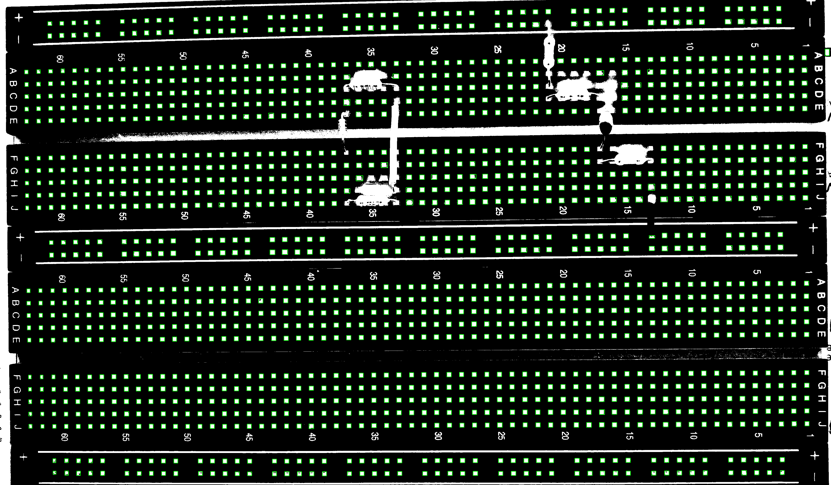

[[{'name': 'Capacitor', 'index_left': 48, 'index_right': 49, 'index_up': 16, 'index_down': 21}], [{'name': 'Diode', 'index_left': 26, 'index_right': 26, 'index_up': 14, 'index_down': 16}], [{'name': 'Resistor', 'index_left': 26, 'index_right': 30, 'index_up': 24, 'index_down': 25}], [{'name': 'Resistor', 'index_left': 26, 'index_right': 30, 'index_up': 9, 'index_down': 11}], [{'name': 'Resistor', 'index_left': 46, 'index_right': 50, 'index_up': 17, 'index_down': 19}], [{'name': 'Resistor', 'index_left': 42, 'index_right': 43, 'index_up': 2, 'index_down': 10}], [{'name': 'Resistor', 'index_left': 42, 'index_right': 46, 'index_up': 11, 'index_down': 13}], [{'name': 'Wire', 'index_left': 26, 'index_right': 26, 'index_up': 14, 'index_down': 17}], [{'name': 'Wire', 'index_left': 30, 'index_right': 30, 'index_up': 12, 'index_down': 23}], [{'name': 'Wire', 'index_left': 50, 'index_right': 50, 'index_up': 23, 'index_down': 27}]]


In [6]:
list_x, list_y, contour_image = detectImage(save_path)

# show the contour image
display(Image.fromarray(contour_image.astype(np.uint8)).resize((int(0.2*contour_image.shape[1]), int(0.2*contour_image.shape[0]))))

l = []
for component in component_list:
    l.append(query_element(list_x, list_y, [component]))
print(l)